# Capstone Project: Hunting Best Neighborhood for living in NYC  
#### Applied Data Science Capstone

### Table of Contents  
1. [Background](#background)
* [Business Problem](#business_problem)
* [Target Audience](#audience)
* [Data Requirement & Sources](#data)
* [Data Collection & Preprocessing](#data_preprocess)
* [Modeling](#modeling)
* [Analysis](#analysis)
* [Results & Discussion](#results)
* [Conclusion](#conclusion)


## 1. Background <a name="background"> </a>

New York City (NYC) is the most populous city in the United States (US) with over 8 million population spread over five boroughs, Brooklyn, Queens, Manhattan, Bronx, and Staten Island. It is well known as global capital of finance, media, and immigrant. NYC is also a global leader in entertainment, fashion, tourism, technology, education, arts, sports, politics, research, and many more industries. The World’s largest stock exchanges operate from the famous financial center Wall Street. Many of the World’s largest financial and media companies are based in NYC.  
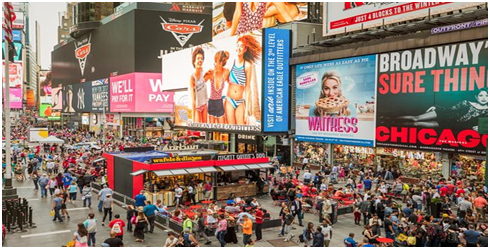  
<p>In brief, NYC is center of opportunities to make the American dream come true. There is no other place like New York to start your living to pursue your American dream no matter where you come from. People around the World migrate here to raise and build better future for their family. Today, you can find the communities representing whole world, in fact more than 800 languages are spoken in NYC. But being the most populous and diverse city in US, it can be very intimidating to find right place to start living in NYC. It may seem easy to find the best place for your family’s new life but people might easily get lost in the process and end up in wrong place. It requires careful and thorough research and decision to find the best place to live with happiness.</p>


## 2. Business Problem <a name="business_problem"> </a>

<p>So, the problem every new city dweller or migrant faces is <b>how to find the best neighborhood to rent a new apartment or to own a new house to start a happy and successful life in NYC?</b> The main objective of this capstone is to develop a k-means clustering model using data science methodology and visualize the clusters in the NYC map by using NYC neighborhood datasets along with Foursquare API to help the new city dwellers to select best possible NYC neighborhood quickly with greater precision. So, this project will greatly simplify the tedious process of hunting the new apartment or house in NYC.</p>


## 3. Target Audience <a name="audience"></a>

Obviously, the new apartment hunters and home owners would be very interested to find the best neighborhoods in NYC to own a home or rent an apartment to start their NYC life successfully. Beside the new city dwellers, the real estate investors, financial institutions, and business investors are also going to be interested to find the best neighborhoods to own the real estate properties. 

## 4. Data Requirements & Sources <a name="data"></a>

<p>To build the machine learning models, first we need the datasets representative of the business problem. For this project, we are going to use following datasets:</p>  

*  We need dataset containing the neighborhoods name and its geographic locations. <a href="https://data.cityofnewyork.us/api/views/xyye-rtrs/rows.csv?accessType=DOWNLOAD">New York City neighborhood dataset</a> contains list of neighborhood names and their geographic coordinates in five boroughs, Brooklyn, Bronx, Manhattan, Queens, and Staten Island. This dataset defines the scope of this project which is the neighborhoods in five boroughs of NYC. 
* The Foursquare venue dataset doesn’t contain the NYC schools information. Because the school information is one of the very important features when searching for apartment or house, I am going to use following NYC schools data sources:  
    - <a href="https://data.cityofnewyork.us/api/views/p6h4-mpyy/rows.csv?accessType=DOWNLOAD">NYC school locations dataset</a> contains list of Elementary, K-8, High school, Junior High-Intermediate-Middle, Secondary School,
       K-12 all grade, and Early Childhood in five boroughs of NYC.   
    - The <a href="https://infohub.nyced.org/docs/default-source/default-document-library/201819_ems_sqr_results.xlsx">performance of middle and elementary schools</a> contains the average ratings and score of students and schools.
    - Similary, the <a href="https://infohub.nyced.org/docs/default-source/default-document-library/201819_hs_sqr_results.xlsx">high schools performance data</a> contains the average rating and score of the student and schools.

* The Foursquare venue dataset doesn’t contain the crime data but it is critical information when making decision for living in new neighborhood. The <a href="https://data.cityofnewyork.us/api/views/5uac-w243/rows.json?accessType=DOWNLOAD">NYC crime dataset</a> contains all valid felony, misdemeanor, and violation crimes reported the New York City Police Department in 2019 and the geographic location of the crimes. This dataset doesn’t contain the neighborhood name. So, I am going to add neighborhood names to the NYC crime dataset based on the crime’s geographic location and its closest neighborhood.

* We are also going to use the venue data returned by the <a href="https://api.foursquare.com/v2/venues/explore?&client_id=%7b%7d&client_secret=%7b%7d&v=%7b%7d&ll=%7b%7d,%7b%7d&radius=%7b%7d&limit=%7b%7d">Foursquare API</a> based on the NYC neighborhoods dataset. This data will be used to perform clustering of the NYC neighborhoods based on the most important venues for living and to raise kids. By clustering the neighborhoods based on the most important venues, it will help to make the neighborhood selection process based on the criterions of individual dweller. 


## 5. Data Collection & Preprocessing <a name="data_preprocess"></a>

### Importing necessary libraries

In [875]:
import pandas as pd
import numpy as np
import requests
import folium
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

To disable auto-scrolling of cell

In [876]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### New York City neighborhood dataset 

In [877]:
# Data Source
url = 'https://data.cityofnewyork.us/api/views/xyye-rtrs/rows.csv?accessType=DOWNLOAD'

In [878]:
# Creating NYC neighborhood dataframe nyc_data
nyc_data = pd.read_csv(url)
print(f'Feature names: {list(nyc_data.columns)}')

Feature names: ['the_geom', 'OBJECTID', 'Name', 'Stacked', 'AnnoLine1', 'AnnoLine2', 'AnnoLine3', 'AnnoAngle', 'Borough']


In [879]:
# Extracting neighborhood, borough, latititude and longitude
nyc_data = nyc_data[['the_geom', 'Name', 'Borough']]
nyc_data['the_geom'] = nyc_data.the_geom.apply(lambda x: x.split('(')[1].split(')')[0].split(' '))
nyc_data['latitude'] = nyc_data.the_geom.apply(lambda x: float(x[1]))
nyc_data['longitude'] = nyc_data.the_geom.apply(lambda x: float(x[0]))
nyc_data.drop('the_geom', axis=1, inplace=True)
nyc_data.columns = ['neighborhood', 'borough', 'latitude', 'longitude']

In [880]:
# checking for missing values
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
neighborhood    299 non-null object
borough         299 non-null object
latitude        299 non-null float64
longitude       299 non-null float64
dtypes: float64(2), object(2)
memory usage: 9.4+ KB


In [881]:
print(f'Total Borough = { len(nyc_data.borough.unique())}')
print(f'Unique neighborhoods names = {len(nyc_data.neighborhood.unique())}')

Total Borough = 5
Unique neighborhoods names = 295


In [882]:
# Checking same neighborhood names in different borough
gp=nyc_data.groupby('neighborhood').count()
gp.loc[gp.borough >= 2]

,borough,latitude,longitude
neighborhood,,,
Bay Terrace,2,2,2
Chelsea,2,2,2
Murray Hill,2,2,2
Sunnyside,2,2,2


In [883]:
# Adding borough name to these four neighborhood names to distinguish each other
n_list =['Bay Terrace', 'Chelsea', 'Murray Hill', 'Sunnyside']
nyc_data['neighborhood'] = nyc_data.apply(lambda x: x.neighborhood + ', ' + x.borough if 
                            x.neighborhood in n_list else x.neighborhood, axis=1)

In [884]:
# Checking total unique neighborhood names
print(f'Total unique neighborhoods = {len(nyc_data.neighborhood.unique())}')

Total unique neighborhoods = 299


In [885]:
# First Five rows:
nyc_data.head()

,neighborhood,borough,latitude,longitude
0,Wakefield,Bronx,40.894705,-73.847201
1,Co-op City,Bronx,40.874294,-73.829939
2,Eastchester,Bronx,40.887556,-73.827806
3,Fieldston,Bronx,40.895437,-73.905643
4,Riverdale,Bronx,40.890834,-73.912585


### NYC School dataset

In [887]:
# Data source for NYC schools
url = "https://data.cityofnewyork.us/api/views/p6h4-mpyy/rows.csv?accessType=DOWNLOAD"
school_df = pd.read_csv(url)

In [888]:
# List of features
list(enumerate(school_df.columns))

[(0, 'FISCAL_YEAR'),
 (1, 'ATS SYSTEM CODE'),
 (2, 'LOCATION_CODE'),
 (3, 'LOCATION_NAME'),
 (4, 'BEDS NUMBER'),
 (5, 'MANAGED_BY_NAME'),
 (6, 'LOCATION_TYPE_DESCRIPTION'),
 (7, 'LOCATION_CATEGORY_DESCRIPTION'),
 (8, 'GRADES_TEXT'),
 (9, 'GRADES_FINAL_TEXT'),
 (10, 'OPEN_DATE'),
 (11, 'STATUS_DESCRIPTIONS'),
 (12, 'PRIMARY_BUILDING_CODE'),
 (13, 'PRIMARY_ADDRESS_LINE_1'),
 (14, 'STATE_CODE'),
 (15, 'X_COORDINATE'),
 (16, 'Y_COORDINATE'),
 (17, 'COMMUNITY_DISTRICT'),
 (18, 'COUNCIL_DISTRICT'),
 (19, 'CENSUS_TRACT'),
 (20, 'BOROUGH_BLOCK_LOT'),
 (21, 'NTA'),
 (22, 'NTA_NAME'),
 (23, 'PRINCIPAL_NAME'),
 (24, 'PRINCIPAL_TITLE'),
 (25, 'PRINCIPAL_PHONE_NUMBER'),
 (26, 'FAX_NUMBER'),
 (27, 'GEOGRAPHICAL_DISTRICT_CODE'),
 (28, 'ADMIN_DISTRICT_LOCATION_CODE'),
 (29, 'ADMINISTRATIVE_DISTRICT_NAME'),
 (30, 'COMMUNITY_SCHOOL_SUP_NAME'),
 (31, 'FIELD_SUPPORT_CENTER_NAME'),
 (32, 'FIELD_SUPPORT_CENTER_LEADER_NAME'),
 (33, 'SCHOOL_SUPPORT_TEAM_NAME'),
 (34, 'SCHOOL_SUPPORT_TEAM_LEADER_NAME'),
 (35, 

In [889]:
# Extracting school code, school name, school type, and location with deep copy
nyc_schools = school_df.iloc[:, [1,3,7,38]].copy()

In [890]:
# Checking missing values
nyc_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823 entries, 0 to 1822
Data columns (total 4 columns):
ATS SYSTEM CODE                  1823 non-null object
LOCATION_NAME                    1823 non-null object
LOCATION_CATEGORY_DESCRIPTION    1823 non-null object
Location 1                       1822 non-null object
dtypes: object(4)
memory usage: 57.0+ KB


In [891]:
# Removing one row with a null value in 'Location 1' column
nyc_schools.dropna(inplace=True)
len(nyc_schools)

1822

In [892]:
# First five rows of the dataframe
nyc_schools.head()

,ATS SYSTEM CODE,LOCATION_NAME,LOCATION_CATEGORY_DESCRIPTION,Location 1
0,01M015,P.S. 015 Roberto Clemente,Elementary,"333 EAST 4 STREET\nMANHATTAN, NY 10009\n(40.72..."
1,01M019,P.S. 019 Asher Levy,Elementary,"185 1 AVENUE\nMANHATTAN, NY 10003\n(40.730009,..."
2,01M020,P.S. 020 Anna Silver,Elementary,"166 ESSEX STREET\nMANHATTAN, NY 10002\n(40.721..."
3,01M034,P.S. 034 Franklin D. Roosevelt,K-8,"730 EAST 12 STREET\nMANHATTAN, NY 10009\n(40.7..."
4,01M063,The STAR Academy - P.S.63,Elementary,"121 EAST 3 STREET\nMANHATTAN, NY 10009\n(40.72..."


In [18]:
# Extracting latitude and longitude from 'Location 1' and cleaning column names
nyc_schools['geolocation'] = nyc_schools['Location 1'].apply(lambda x: str(x).split('\n')[-1].split('(')[-1].split(')')[0].split(','))
nyc_schools['latitude'] = nyc_schools['geolocation'].apply(lambda x: float(x[0]))
nyc_schools['longitude'] = nyc_schools['geolocation'].apply(lambda x: float(x[1]))
nyc_schools = nyc_schools.iloc[:, [0,1,2,5,6]]
nyc_schools.columns = ['dbn', 'school_name', 'school_type', 'latitude', 'longitude']
# Removing preceding and trailing spaces
nyc_schools.dbn = nyc_schools.dbn.apply(lambda x: x.strip())

In [19]:
nyc_schools.head()

,dbn,school_name,school_type,latitude,longitude
0,01M015,P.S. 015 Roberto Clemente,Elementary,40.722075,-73.978747
1,01M019,P.S. 019 Asher Levy,Elementary,40.730009,-73.984496
2,01M020,P.S. 020 Anna Silver,Elementary,40.721305,-73.986312
3,01M034,P.S. 034 Franklin D. Roosevelt,K-8,40.726008,-73.975058
4,01M063,The STAR Academy - P.S.63,Elementary,40.724440,-73.986214


There are some inconsistencies in neighborhood naming in NYC Neighborhood dataset source and NYC schools dataset source. I am going to use NYC Neighborhood dataset as the reference for neighborhood names for all schools. I am creating following function to find out the neighborhood of the schools based on the nearest neighborhood.

In [20]:
def get_val(df1, df2, val_col):
    '''df1: dataframe that you want to use apply()
       df2: the reference dataframe
       val_col: name of the column in reference dataframe which you want to return
    '''
    dis_list = []
    x1=df1['latitude']
    y1=df1['longitude']
    temp = df2.loc[(df2.latitude.round(2) == round(x1, 2)) | 
                       (df2.longitude.round(2) == round(y1, 2))]
    temp = df2 if len(temp) == 0 else temp.reset_index(drop=True)
    
    for i in range(len(temp)):
        x2 = temp.at[i,'latitude']
        y2 = temp.at[i,'longitude']
        dis_list.append(geodesic((x1,y1), (x2, y2)).miles)
    
    return temp.at[dis_list.index(min(dis_list)), val_col]      

In [21]:
# Adding neighborhood in nyc_schools dataframe using get_val()
nyc_schools['neighborhood'] = nyc_schools.apply(get_val, axis=1, df2=nyc_data, val_col='neighborhood')

In [22]:
nyc_schools.head()

,dbn,school_name,school_type,latitude,longitude,neighborhood
0,01M015,P.S. 015 Roberto Clemente,Elementary,40.722075,-73.978747,Lower East Side
1,01M019,P.S. 019 Asher Levy,Elementary,40.730009,-73.984496,East Village
2,01M020,P.S. 020 Anna Silver,Elementary,40.721305,-73.986312,Noho
3,01M034,P.S. 034 Franklin D. Roosevelt,K-8,40.726008,-73.975058,Stuyvesant Town
4,01M063,The STAR Academy - P.S.63,Elementary,40.724440,-73.986214,Noho


In [23]:
# checking dataframe size and duplicate schools
len(nyc_schools), len(nyc_schools.dbn.unique())

(1822, 1822)

I am going to use the performance of schools for selecting the neighborhoods. Lets create dataframe of schools' ratings based on the students' performance.

In [24]:
# Data source of school quality report of middle and elementary schools
ems_ratings = pd.read_excel("https://infohub.nyced.org/docs/default-source/default-document-library/201819_ems_sqr_results.xlsx",
                        sheet_name="Student Achievement", skiprows=[0,1,2], 
                        dtype={'Student Achievement - Section Score': 'float64'}, na_values=['.'])
# Extracting school number, & student achievement rating
ems_ratings = ems_ratings.iloc[1:, [3,4,6,7]].reset_index(drop=True)
ems_ratings.columns = ['dbn', 'school_name','student_rating', 'student_score']

# Data source of school quality report of high schools
hs_ratings = pd.read_excel('https://infohub.nyced.org/docs/default-source/default-document-library/201819_hs_sqr_results.xlsx',
                        sheet_name="Student Achievement", skiprows=[0,1,2], 
                        dtype={'Student Achievement - Section Score': 'float64'}, na_values=['.'])
# Extracting school number, & student achievement rating
hs_ratings = hs_ratings.iloc[1:, [3,4,6,7]].reset_index(drop=True)
hs_ratings.columns = ['dbn', 'school_name','student_rating', 'student_score']

Checking missing student rating values

In [25]:
ems_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 4 columns):
dbn               1292 non-null object
school_name       1292 non-null object
student_rating    1212 non-null object
student_score     1212 non-null float64
dtypes: float64(1), object(3)
memory usage: 40.5+ KB


In [26]:
hs_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 4 columns):
dbn               486 non-null object
school_name       486 non-null object
student_rating    463 non-null object
student_score     463 non-null float64
dtypes: float64(1), object(3)
memory usage: 15.3+ KB


There are some missing rating and score values. We will handle that later.

In [27]:
# Merging all ratings together
ratings = pd.concat([ems_ratings, hs_ratings], axis = 0, ignore_index=True)

In [28]:
# Checking dataframe size
len(ratings), len(ems_ratings) + len(hs_ratings)

(1778, 1778)

In [29]:
# There are some duplicates schools numbers in the dataframe
len(ratings.dbn.unique())

1652

In [30]:
# Removing the duplicate schools
ratings.sort_values('student_score', ascending=False, inplace=True)
ratings.drop_duplicates(subset='dbn', keep='first', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [31]:
# Checking dataframe size
len(ratings)

1652

In [32]:
ratings.head()

,dbn,school_name,student_rating,student_score
0,02M126,P.S. 126 Jacob August Riis,Exceeding Target,4.99
1,84K125,Success Academy Charter School - Bed-Stuy 2,Exceeding Target,4.99
2,84K182,Success Academy Charter School - Williamsburg,Exceeding Target,4.99
3,30Q234,P.S. 234,Exceeding Target,4.99
4,02M124,P.S. 124 Yung Wing,Exceeding Target,4.99


Now, creating the final school dataframe that includes elementary, middle and high schools with the school students' performance using concatenation.

In [33]:
# Merging nyc_schools with ratings
nyc_schools = pd.merge(nyc_schools, ratings[['dbn', 'student_rating', 'student_score']], on ='dbn')

In [34]:
nyc_schools.head()

,dbn,school_name,school_type,latitude,longitude,neighborhood,student_rating,student_score
0,01M015,P.S. 015 Roberto Clemente,Elementary,40.722075,-73.978747,Lower East Side,Exceeding Target,4.86
1,01M019,P.S. 019 Asher Levy,Elementary,40.730009,-73.984496,East Village,Exceeding Target,4.09
2,01M020,P.S. 020 Anna Silver,Elementary,40.721305,-73.986312,Noho,Meeting Target,3.82
3,01M034,P.S. 034 Franklin D. Roosevelt,K-8,40.726008,-73.975058,Stuyvesant Town,Not Meeting Target,1.74
4,01M063,The STAR Academy - P.S.63,Elementary,40.724440,-73.986214,Noho,Meeting Target,3.15


In [35]:
# Checking school_type categories
nyc_schools.school_type.unique()

array(['Elementary', 'K-8', 'High school',
       'Junior High-Intermediate-Middle', 'Secondary School',
       'K-12 all grades', 'Early Childhood'], dtype=object)

Let's unify the school types into into 3 categories, Elementary, Middle School, and High School. 

In [36]:
types = {"Elementary": "elementary", "K-8": "middle_school", "High school": "high_school", 
         "Junior High-Intermediate-Middle": "middle_school", "Secondary School": "high_school",
        "K-12 all grades":"high_school", "Early Childhood": "elementary"}
nyc_schools['school_type'] = nyc_schools.school_type.apply(lambda x: types[x])

In [37]:
# Checking school_type categories again
nyc_schools.school_type.unique()

array(['elementary', 'middle_school', 'high_school'], dtype=object)

In [38]:
# Checking student_rating category
nyc_schools.student_rating.unique()

array(['Exceeding Target', 'Meeting Target', 'Not Meeting Target',
       'Approaching Target', nan], dtype=object)

In [39]:
# Lets clean category names with lower case and '_' for space
nyc_schools.student_rating = nyc_schools.student_rating.apply(lambda x: x.lower().replace(' ', '_') 
                                                              if not pd.isnull(x) else x )

In [40]:
nyc_schools.student_rating.unique()

array(['exceeding_target', 'meeting_target', 'not_meeting_target',
       'approaching_target', nan], dtype=object)

In [41]:
# First five rows of final version
nyc_schools.head()

,dbn,school_name,school_type,latitude,longitude,neighborhood,student_rating,student_score
0,01M015,P.S. 015 Roberto Clemente,elementary,40.722075,-73.978747,Lower East Side,exceeding_target,4.86
1,01M019,P.S. 019 Asher Levy,elementary,40.730009,-73.984496,East Village,exceeding_target,4.09
2,01M020,P.S. 020 Anna Silver,elementary,40.721305,-73.986312,Noho,meeting_target,3.82
3,01M034,P.S. 034 Franklin D. Roosevelt,middle_school,40.726008,-73.975058,Stuyvesant Town,not_meeting_target,1.74
4,01M063,The STAR Academy - P.S.63,elementary,40.724440,-73.986214,Noho,meeting_target,3.15


##### Option: If you have trouble creating nyc_schools dataframe, read "nyc_schools.csv" file instead by uncommenting below.

In [893]:
# nyc_schools = pd.read_csv("nyc_schools.csv")

In [301]:
# checking size of nyc_schools
len(nyc_schools.dbn.unique()), len(nyc_schools), len(nyc_schools.school_name.unique())

(1638, 1638, 1630)

Now, I am going to create a dataframe with school types as features with number of each type as its values using groupby() and unstack() functions.

In [305]:
# Grouping by two features and counting number of each school type in each neighborhood.
groups = nyc_schools.groupby(['neighborhood', 'school_type'])['school_type'].count() #agg(['mean', 'count'])

In [306]:
# Changing 'school_type' index to features and droping first column level
school_types = groups.to_frame().unstack(level=1).droplevel(level=0, axis=1)
# Deleting column name attribute
school_types.columns.name = ""
# Moving 'neighborhood' index to column
school_types.reset_index(inplace=True)
# Filling missing value with 0 indicating no school in neighborhood
school_types.fillna(0, inplace=True)

In [307]:
school_types.head()

,neighborhood,elementary,high_school,middle_school
0,Annadale,1.0,0.0,1.0
1,Arden Heights,2.0,0.0,0.0
2,Arrochar,1.0,0.0,0.0
3,Arverne,1.0,4.0,4.0
4,Astoria,4.0,1.0,2.0


In [308]:
# Checking missing values
school_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 4 columns):
neighborhood     264 non-null object
elementary       264 non-null float64
high_school      264 non-null float64
middle_school    264 non-null float64
dtypes: float64(3), object(1)
memory usage: 8.3+ KB


Similarly, lets create another dataframe with student ratings as features with number of each rating type as its values.

In [309]:
groups = nyc_schools.groupby(['neighborhood', 'student_rating'])['student_rating'].count() #agg(['mean', 'count'])
student_ratings = groups.to_frame().unstack(level=1).droplevel(level=0, axis=1)
student_ratings.columns.name = ""
student_ratings.reset_index(inplace=True)
student_ratings.fillna(0, inplace=True)

In [310]:
student_ratings.head()

,neighborhood,approaching_target,exceeding_target,meeting_target,not_meeting_target
0,Annadale,0.0,0.0,2.0,0.0
1,Arden Heights,0.0,1.0,1.0,0.0
2,Arrochar,0.0,0.0,1.0,0.0
3,Arverne,6.0,0.0,2.0,1.0
4,Astoria,2.0,3.0,2.0,0.0


In [311]:
# Checking missing values
student_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 5 columns):
neighborhood          262 non-null object
approaching_target    262 non-null float64
exceeding_target      262 non-null float64
meeting_target        262 non-null float64
not_meeting_target    262 non-null float64
dtypes: float64(4), object(1)
memory usage: 10.3+ KB


Now, lets create our training dataframe, <b>nyc_df</b>, by merging three dataframes, nyc_data, school_types, and student_ratings. Not all neighborhoods in nyc_data dataframe have schools. So, I am going to do left join to retain all neighborhoods in nyc_data dataframe.

In [312]:
nyc_df = pd.merge(nyc_data, school_types, how= 'left', on = 'neighborhood')
nyc_df = pd.merge(nyc_df, student_ratings, how = 'left', on = 'neighborhood')

In [313]:
# Comparing sizes of new dataframe with nyc_data
len(nyc_df), len(nyc_data)

(299, 299)

In [314]:
nyc_df.head()

,neighborhood,borough,latitude,longitude,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target
0,Wakefield,Bronx,40.894705,-73.847201,4.0,0.0,0.0,0.0,1.0,3.0,0.0
1,Co-op City,Bronx,40.874294,-73.829939,2.0,2.0,2.0,3.0,1.0,2.0,0.0
2,Eastchester,Bronx,40.887556,-73.827806,1.0,0.0,4.0,4.0,0.0,1.0,0.0
3,Fieldston,Bronx,40.895437,-73.905643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Riverdale,Bronx,40.890834,-73.912585,1.0,1.0,0.0,0.0,0.0,2.0,0.0


In [315]:
# Checking missing values
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 298
Data columns (total 11 columns):
neighborhood          299 non-null object
borough               299 non-null object
latitude              299 non-null float64
longitude             299 non-null float64
elementary            264 non-null float64
high_school           264 non-null float64
middle_school         264 non-null float64
approaching_target    262 non-null float64
exceeding_target      262 non-null float64
meeting_target        262 non-null float64
not_meeting_target    262 non-null float64
dtypes: float64(9), object(2)
memory usage: 28.0+ KB


In [316]:
# Lets fill missing values with 0 since the neighborhoods with no schools have NaN values.
nyc_df.fillna(0, inplace=True)
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 298
Data columns (total 11 columns):
neighborhood          299 non-null object
borough               299 non-null object
latitude              299 non-null float64
longitude             299 non-null float64
elementary            299 non-null float64
high_school           299 non-null float64
middle_school         299 non-null float64
approaching_target    299 non-null float64
exceeding_target      299 non-null float64
meeting_target        299 non-null float64
not_meeting_target    299 non-null float64
dtypes: float64(9), object(2)
memory usage: 28.0+ KB


In [317]:
nyc_df.head()

,neighborhood,borough,latitude,longitude,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target
0,Wakefield,Bronx,40.894705,-73.847201,4.0,0.0,0.0,0.0,1.0,3.0,0.0
1,Co-op City,Bronx,40.874294,-73.829939,2.0,2.0,2.0,3.0,1.0,2.0,0.0
2,Eastchester,Bronx,40.887556,-73.827806,1.0,0.0,4.0,4.0,0.0,1.0,0.0
3,Fieldston,Bronx,40.895437,-73.905643,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Riverdale,Bronx,40.890834,-73.912585,1.0,1.0,0.0,0.0,0.0,2.0,0.0


### NYC Crime data reported to NYPD in 2019

In [57]:
# Data source of NYC crimes data reported to NYPD in 2019
crime_json = requests.get('https://data.cityofnewyork.us/api/views/5uac-w243/rows.json?accessType=DOWNLOAD').json()

In [58]:
# Checking features of crime data 
[d['name'] for d in crime_json['meta']['view']['columns']]

['sid',
 'id',
 'position',
 'created_at',
 'created_meta',
 'updated_at',
 'updated_meta',
 'meta',
 'CMPLNT_NUM',
 'ADDR_PCT_CD',
 'BORO_NM',
 'CMPLNT_FR_DT',
 'CMPLNT_FR_TM',
 'CMPLNT_TO_DT',
 'CMPLNT_TO_TM',
 'CRM_ATPT_CPTD_CD',
 'HADEVELOPT',
 'HOUSING_PSA',
 'JURISDICTION_CODE',
 'JURIS_DESC',
 'KY_CD',
 'LAW_CAT_CD',
 'LOC_OF_OCCUR_DESC',
 'OFNS_DESC',
 'PARKS_NM',
 'PATROL_BORO',
 'PD_CD',
 'PD_DESC',
 'PREM_TYP_DESC',
 'RPT_DT',
 'STATION_NAME',
 'SUSP_AGE_GROUP',
 'SUSP_RACE',
 'SUSP_SEX',
 'TRANSIT_DISTRICT',
 'VIC_AGE_GROUP',
 'VIC_RACE',
 'VIC_SEX',
 'X_COORD_CD',
 'Y_COORD_CD',
 'Latitude',
 'Longitude',
 'Lat_Lon',
 'Zip Codes',
 'Community Districts',
 'Borough Boundaries',
 'City Council Districts',
 'Police Precincts']

In [59]:
# Extracting crime id, crime level, latitude and longitude of crime
rows = []
crime_num = len(crime_json['data'])
for row in range(crime_num):
    rows.append(crime_json['data'][row][8:])
crime_df = pd.DataFrame(rows)
crime_df = crime_df.iloc[:,[0,13, 32,33]]
crime_df.columns = ['crime_id', 'crime_level', 'latitude', 'longitude']
crime_df=crime_df.astype({'latitude':'float64', 'longitude': 'float64'})

In [60]:
crime_df.head()

,crime_id,crime_level,latitude,longitude
0,314773184,FELONY,40.838026,-73.881681
1,289837961,MISDEMEANOR,40.800334,-73.945657
2,535744284,FELONY,40.669832,-73.939376
3,895678119,MISDEMEANOR,40.873671,-73.908014
4,299841674,MISDEMEANOR,40.760935,-73.994529


In [61]:
# Checking for missing values
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461711 entries, 0 to 461710
Data columns (total 4 columns):
crime_id       461711 non-null object
crime_level    461711 non-null object
latitude       461711 non-null float64
longitude      461711 non-null float64
dtypes: float64(2), object(2)
memory usage: 14.1+ MB


There are no missing values but this dataset doesn't contain neighborhood names of the crime location. I am going to
use the get_val() I created earlier to get neighborhood names based on the crime latitude and longitude.

###### Note: Following code is going to take more than 30 minutes. You can read the 'nyc_crime.csv' file I created instead.

In [65]:
# Adding crime_neighborhoods in crime_df
crime_neighborhoods = crime_df.apply(get_val, axis=1, df2=nyc_data, val_col='neighborhood')
crime_df['neighborhood'] = crime_neighborhoods

##### Option: Read "nyc_crime.csv" for fast solution instead of running above code by uncommenting below.

In [872]:
# crime_df = pd.read_csv('nyc_crime.csv')

In [873]:
crime_df.head()

,crime_id,crime_level,latitude,longitude,neighborhood
0,314773184,FELONY,40.838026,-73.881681,West Farms
1,289837961,MISDEMEANOR,40.800334,-73.945657,Manhattan Valley
2,535744284,FELONY,40.669832,-73.939376,Crown Heights
3,895678119,MISDEMEANOR,40.873671,-73.908014,Marble Hill
4,299841674,MISDEMEANOR,40.760935,-73.994529,Clinton


In [321]:
# Lets check types of crime_level
crime_df.crime_level.unique()

array(['FELONY', 'MISDEMEANOR', 'VIOLATION'], dtype=object)

As we did to school dataframe, lets create a dataframe with crime levels as features and number of each type as value in each neighborhood by using groupby() and unstack() functions.

In [322]:
# Grouping by two features and changing 'crime_level' index to features
crime_levels = crime_df.groupby(['neighborhood', 'crime_level'])['crime_level'].count().unstack(level=1)
# Changing column names to lower case
crime_levels.columns = list(map(lambda x: x.lower(), crime_levels.columns))
crime_levels.columns.name = ''
# Moving 'neighborhood' from index to column
crime_levels.reset_index(inplace=True)
crime_levels.head()

,neighborhood,felony,misdemeanor,violation
0,Annadale,21.0,82.0,27.0
1,Arden Heights,88.0,125.0,68.0
2,Arlington,115.0,253.0,79.0
3,Arrochar,73.0,141.0,91.0
4,Arverne,481.0,744.0,320.0


In [323]:
# Checking size and missing values
crime_levels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
neighborhood    299 non-null object
felony          299 non-null float64
misdemeanor     299 non-null float64
violation       298 non-null float64
dtypes: float64(3), object(1)
memory usage: 9.4+ KB


In [324]:
# Checking row with the missing value
crime_levels.loc[crime_levels.violation.isna()]

,neighborhood,felony,misdemeanor,violation
129,Howland Hook,1.0,7.0,NaN


In [325]:
# Since there is no violation in Howland Hook,fill the missing value with 0
crime_levels.fillna(0, inplace=True)

Now, lets merge the crime_levels dataframe to nyc_df.

In [326]:
nyc_df = pd.merge(nyc_df, crime_levels, how = "left", on = "neighborhood")

In [327]:
nyc_df.head()

,neighborhood,borough,latitude,longitude,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation
0,Wakefield,Bronx,40.894705,-73.847201,4.0,0.0,0.0,0.0,1.0,3.0,0.0,524.0,1063.0,360.0
1,Co-op City,Bronx,40.874294,-73.829939,2.0,2.0,2.0,3.0,1.0,2.0,0.0,311.0,692.0,184.0
2,Eastchester,Bronx,40.887556,-73.827806,1.0,0.0,4.0,4.0,0.0,1.0,0.0,190.0,324.0,126.0
3,Fieldston,Bronx,40.895437,-73.905643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,104.0,21.0
4,Riverdale,Bronx,40.890834,-73.912585,1.0,1.0,0.0,0.0,0.0,2.0,0.0,124.0,202.0,68.0


In [328]:
# Checking missing values
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 298
Data columns (total 14 columns):
neighborhood          299 non-null object
borough               299 non-null object
latitude              299 non-null float64
longitude             299 non-null float64
elementary            299 non-null float64
high_school           299 non-null float64
middle_school         299 non-null float64
approaching_target    299 non-null float64
exceeding_target      299 non-null float64
meeting_target        299 non-null float64
not_meeting_target    299 non-null float64
felony                299 non-null float64
misdemeanor           299 non-null float64
violation             299 non-null float64
dtypes: float64(12), object(2)
memory usage: 35.0+ KB


### Venue Dataset from Foursquare API

In [329]:
# Foursquare client_id, client_secret from your foursquare account
CLIENT_ID = 'FOB3MKIYUMLEZAF00B0YWFHKKZPGE2FT1L4GO1RPL4HD3NRS' # your Foursquare ID
CLIENT_SECRET = 'W3VRIBWFXKJDPR1PXLC1TQEJLT3VRKK2MJE15PLDI3M5E3KE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

I am going to select only relevant venue types from the venue data returned by this API. This may depend on indivisual preferences. So, different users may customize the list of venue types they want to include.

In [145]:
# Foursquare API for list of venue categories that its venue API returns
category_url = '''https://api.foursquare.com/v2/venues/categories?&client_id={}
            &client_secret={}&v={}'''.format(CLIENT_ID, CLIENT_SECRET, VERSION)

In [75]:
# GET request
response = requests.get(category_url).json()

In [76]:
# list of main categories
categories = response['response']['categories']

In [77]:
# Lets print name of the main categories
for i, c in enumerate(categories):
    print(i, c['name'])

0 Arts & Entertainment
1 College & University
2 Event
3 Food
4 Nightlife Spot
5 Outdoors & Recreation
6 Professional & Other Places
7 Residence
8 Shop & Service
9 Travel & Transport


Now, I am going to extract all the venue categories listed under the main categories: <b>'Shop & Service','Professional & Other Places','Travel & Transport','Arts & Entertainment', and 'Outdoors & Recreation'.</b>

In [78]:
# You may include other main categories from above list or remove from cat_list
cat_list = ['Shop & Service','Professional & Other Places','Travel & Transport',
            'Arts & Entertainment', 'Outdoors & Recreation']
venue_list = []
for c in categories:
    if c['name'] in cat_list:
        for venue in c['categories']:
            if len(venue['categories']) != 0:
                for v in venue['categories']:
                    venue_list.append(v['name'])                        
            else:
                venue_list.append(venue['name'])
                
### Saving venue_list in csv file so I could manually select 
### the venue names from the file and read the file back.
# Uncomment below if you want to customize your own venues.csv file
# pd.DataFrame({'venue_type': venue_list}).to_csv('venues.csv', index=False)

For this project, I customized the venues.csv file and going to select the venues types
that are listed in this file.

In [330]:
venues = pd.read_csv('venues.csv')

In [331]:
venues.head()

,venue_type
0,restaurant
1,Amphitheater
2,Aquarium
3,Arcade
4,Art Gallery


Lets create a function to extract all venues around each neighborhood within 1000 meter radius using Foursqare Venue API.

In [81]:
def get_venues(neighborhood, latitude, longitude, radius=1000):
    '''neighborhood: list of neighborhood name
       latitidue: list of neighborhood latitude
       longitude: list of neighborhood longitude
    '''
    venues_list=[]
    for name, lat, lng in zip(neighborhood, latitude, longitude):
        # create the API request URL
        url = '''https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret=
                {}&v={}&ll={},{}&radius={}&limit={}'''.format(
                CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( name, v['venue']['name'], 
                        v['venue']['categories'][0]['name']) for v in results])

    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = ['neighborhood', 'venue', 'venue_type']
    
    return(venues_df)

In [342]:
# Extracting venues around each neighborhood using get_venues() function
venues_df = get_venues(nyc_df.neighborhood, nyc_df.latitude, nyc_df.longitude)

<b>Option: In case, you can't run get_venues() function, you can read 'venues_df.csv' I created by uncommenting below.</b>

In [844]:
# venues_df = pd.read_csv("venues_df.csv")

In [334]:
# Checking size
len(venues_df)

20215

In [845]:
# Lets change all types of restaurants to one venue type, 'restaurant'.
venues_df.venue_type = venues_df.venue_type.apply(lambda x: 'restaurant' if 'Restaurant' in x else x)

In [846]:
# Lets filter the desired venues by merging venues_df and customized venues.
venues_df = pd.merge(venues_df, venues, on = "venue_type")

In [847]:
# Checking size
len(venues_df)

8541

In [848]:
venues_df.head()

,neighborhood,venue,venue_type
0,Wakefield,Ripe Kitchen & Bar,restaurant
1,Wakefield,Ali's Roti Shop,restaurant
2,Wakefield,Jackie's West Indian Bakery,restaurant
3,Wakefield,Cooler Runnings Jamaican Restaurant Inc,restaurant
4,Wakefield,McDonald's,restaurant


In [849]:
# Checking number of unique venue_type
print(f'We have {len(venues_df.venue_type.unique())} unique venue types')

We have 93 unique venue types


As before, lets create new dataframe with venue types as features and number of each venue types as its value using groupby() and unstack() functions.

In [850]:
venue_types = venues_df.groupby(['neighborhood', 'venue_type']).count().unstack(level=1).droplevel(level=0, axis=1)
venue_types.columns.name = ''
venue_types.reset_index(inplace=True)
# Changing columns names to lowercase and connect with '_' for consistency.
venue_types.columns = [c.lower().replace(' / ', ' ').replace(' ', '_') for c in venue_types.columns]
# Fill NaN with 0
venue_types.fillna(0, inplace=True)
# Moving restaurant to second column from last
venue_types = venue_types[[venue_types.columns[0]] + [venue_types.columns[-1]] + list(venue_types.columns[1:-1])]
venue_types.head()

,neighborhood,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
0,Annadale,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arlington,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arrochar,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arverne,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [851]:
# Checking shape of venue_types datafram
venue_types.shape

(299, 94)

Now, lets do left merge venue_types with nyc_df.

In [852]:
nyc_df = pd.merge(nyc_df, venue_types, how = "left", on = "neighborhood")

In [853]:
nyc_df.head()

,neighborhood,borough,latitude,longitude,cluster,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant_x,amphitheater_x,aquarium_x,arcade_x,art_gallery_x,art_museum_x,bank_x,baseball_field_x,baseball_stadium_x,basketball_court_x,basketball_stadium_x,bike_rental_bike_share_x,bike_trail_x,botanical_garden_x,bowling_alley_x,bridge_x,bus_line_x,bus_stop_x,campground_x,comedy_club_x,concert_hall_x,dance_studio_x,department_store_x,doctor's_office_x,exhibit_x,factory_x,farm_x,farmers_market_x,food_service_x,garden_x,general_entertainment_x,go_kart_track_x,golf_course_x,golf_driving_range_x,gourmet_shop_x,grocery_store_x,gym_fitness_center_x,harbor_marina_x,historic_site_x,history_museum_x,indie_movie_theater_x,indie_theater_x,indoor_play_area_x,jazz_club_x,lake_x,library_x,lighthouse_x,memorial_site_x,metro_station_x,mini_golf_x,monument_landmark_x,multiplex_x,national_park_x,opera_house_x,organic_grocery_x,other_great_outdoors_x,outdoor_sculpture_x,paintball_field_x,park_x,pet_service_x,pet_store_x,pharmacy_x,piano_bar_x,playground_x,pool_x,pool_hall_x,post_office_x,racetrack_x,recreation_center_x,river_x,rock_club_x,salon_barbershop_x,science_museum_x,shopping_mall_x,shopping_plaza_x,skate_park_x,skating_rink_x,soccer_field_x,sports_club_x,storage_facility_x,street_art_x,supermarket_x,surf_spot_x,tennis_court_x,tennis_stadium_x,theater_x,theme_park_ride_attraction_x,tour_provider_x,track_stadium_x,train_x,volleyball_court_x,waterfront_x,zoo_exhibit_x,restaurant_y,amphitheater_y,aquarium_y,arcade_y,art_gallery_y,art_museum_y,bank_y,baseball_field_y,baseball_stadium_y,basketball_court_y,basketball_stadium_y,bike_rental_bike_share_y,bike_trail_y,botanical_garden_y,bowling_alley_y,bridge_y,bus_line_y,bus_stop_y,campground_y,comedy_club_y,concert_hall_y,dance_studio_y,department_store_y,doctor's_office_y,exhibit_y,factory_y,farm_y,farmers_market_y,food_service_y,garden_y,general_entertainment_y,go_kart_track_y,golf_course_y,golf_driving_range_y,gourmet_shop_y,grocery_store_y,gym_fitness_center_y,harbor_marina_y,historic_site_y,history_museum_y,indie_movie_theater_y,indie_theater_y,indoor_play_area_y,jazz_club_y,lake_y,library_y,lighthouse_y,memorial_site_y,metro_station_y,mini_golf_y,monument_landmark_y,multiplex_y,national_park_y,opera_house_y,organic_grocery_y,other_great_outdoors_y,outdoor_sculpture_y,paintball_field_y,park_y,pet_service_y,pet_store_y,pharmacy_y,piano_bar_y,playground_y,pool_y,pool_hall_y,post_office_y,racetrack_y,recreation_center_y,river_y,rock_club_y,salon_barbershop_y,science_museum_y,shopping_mall_y,shopping_plaza_y,skate_park_y,skating_rink_y,soccer_field_y,sports_club_y,storage_facility_y,street_art_y,supermarket_y,surf_spot_y,tennis_court_y,tennis_stadium_y,theater_y,theme_park_ride_attraction_y,tour_provider_y,track_stadium_y,train_y,volleyball_court_y,waterfront_y,zoo_exhibit_y
0,Wakefield,Bronx,40.894705,-73.847201,1,4.0,0.0,0.0,0.0,1.0,3.0,0.0,524.0,1063.0,360.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Co-op City,Bronx,40.874294,-73.829939,1,2.0,2.0,2.0,3.0,1.0,2.0,0.0,311.0,692.0,184.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

##### Note: If you need to get nyc_df dataset in this state, run following code to read the pre-prepared file.

In [894]:
# nyc_df = pd.read_csv("nyc_df.csv")

In [895]:
# Checking missing values
nyc_df.isna().sum().sum()

0

In [896]:
nyc_df.shape

(299, 107)

In [897]:
# Lets check features variances
nyc_df.var().to_frame().T

,latitude,longitude,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
0,0.009345,0.014818,6.160019,5.988373,4.340082,4.066935,3.647842,7.382663,0.15654,220844.618213,668993.405423,52451.967902,121.786649,0.003344,0.0301,0.052075,0.592894,0.16563,1.855402,0.427892,0.072209,0.075105,0.006667,0.003344,0.013243,0.026442,0.053804,0.052075,0.060515,0.941977,0.019955,0.026442,0.109605,0.20646,0.624588,0.02294,0.419946,0.013243,0.039146,0.164284,0.003344,0.102557,0.016498,0.009966,0.070189,0.003344,0.294,2.194496,1.432269,0.288299,0.090301,0.095845,0.083612,0.083612,0.003344,0.162353,0.02294,0.016498,0.003344,0.043344,0.186326,0.016498,0.05515,0.009966,0.003344,0.043074,0.032435,0.061233,0.016498,0.003344,2.758816,0.026127,0.267154,1.984108,0.003344,0.646473,0.084667,0.032839,0.003344,0.003344,0.016498,0.013243,0.049426,0.284797,0.033377,0.229176,0.013243,0.032435,0.026127,0.035555,0.01973,0.050818,0.013243,1.05753,0.066396,0.103993,0.105766,0.830307,0.77877,0.003344,0.003344,0.006667,0.013243,0.01973,0.046576


Since the variances of features vary very widely. So, I am going to normalize nyc_df using <b>StandardScaler</b>.

In [898]:
training_data = nyc_df.iloc[:,4:]
training_data.head()

,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
0,4.0,0.0,0.0,0.0,1.0,3.0,0.0,524.0,1063.0,360.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2.0,2.0,3.0,1.0,2.0,0.0,311.0,692.0,184.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,4.0,4.0,0.0,1.0,0.0,190.0,324.0,126.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,104.0,21.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,2.0,0.0,124.0,202.0,68.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [899]:
# Standardizing the dataset
scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)

In [900]:
# First 3 rows and first 5 columns
training_data[:3,:5]

array([[ 0.68974118, -0.66259357, -0.75418891, -0.71930086, -0.14207684],
       [-0.11743147,  0.15606543,  0.20744215,  0.77079815, -0.14207684],
       [-0.5210178 , -0.66259357,  1.16907321,  1.26749782, -0.66653333]])

## 6. Modeling: K-Means Clustering <a name="modeling"> </a>

First, lets do hyperparameter tuning of KMeans clustering using Elbow method. 

In [663]:
# Running k-means for nine different cluseter number.
sse = []
n_clusters = range(1,20)
for k in n_clusters:
    km = KMeans(n_clusters=k)
    km = km.fit(training_data)
    sse.append(km.inertia_)

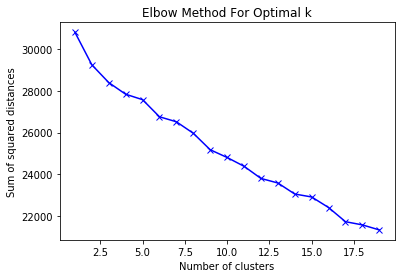

In [664]:
plt.plot(n_clusters, sse, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Lets pick 16 as optimal number of clusters for this project, but I also found 8 is also good choice.

In [901]:
n_clusters = 16
kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(training_data)
# Getting cluster labels generated for each row in the nyc_df
labels = kmeans.labels_
print(f'Number of labels: {len(labels)}')

Number of labels: 299


In [902]:
# First ten cluster lebels
labels[:10]

array([1, 1, 1, 3, 3, 1, 1, 3, 1, 1])

Lets add cluster labels to the nyc_df.

In [903]:
# Inserting cluster labels after 'longitude' column.
nyc_df.insert(4, 'cluster', labels)

In [904]:
nyc_df.head()

,neighborhood,borough,latitude,longitude,cluster,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
0,Wakefield,Bronx,40.894705,-73.847201,1,4.0,0.0,0.0,0.0,1.0,3.0,0.0,524.0,1063.0,360.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Co-op City,Bronx,40.874294,-73.829939,1,2.0,2.0,2.0,3.0,1.0,2.0,0.0,311.0,692.0,184.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Eastchester,Bronx,40.887556,-73.827806,1,1.0,0.0,4.0,4.0,0.0,1.0,0.0,190.0,324.0,126.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fieldston,Bronx,40.895437,-73.905643,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,104.0,21.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Riverdale,Bronx,40.890834,-73.912585,3,1.0,1.0,0.0,0.0,0.0,2.0,0.0,124.0,202.0,68.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, lets visualize the neighborhood <b>clusters</b>.

In [905]:
# Location of Sunnyside, Queens neighborhood, located in the middle of NYC.
latitude = nyc_df.loc[nyc_df.neighborhood == 'Sunnyside, Queens', 'latitude']
longitude = nyc_df.loc[nyc_df.neighborhood == 'Sunnyside, Queens', 'longitude']

In [906]:
# Create folium map of Sunnyside, NYC
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lgn, neighbor, cluster in zip(nyc_df['latitude'], nyc_df['longitude'], nyc_df['neighborhood'], nyc_df['cluster']):
    label = folium.Popup(str(neighbor) + ': cluster-' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lgn],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

In [ ]:
# Because folium map doesn't work on github, displaying the folium map statically
display(Image(filename='neighborhood_clusters.png', embed=True))

## 7. Analysis  <a name="analysis"> </a>


Lets visualize in heatmap

In [907]:
# Creating dataframe for heatmap 
heat_df = nyc_df.iloc[:, 4:]

In [908]:
heat_df.head()

,cluster,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
0,1,4.0,0.0,0.0,0.0,1.0,3.0,0.0,524.0,1063.0,360.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,2.0,2.0,3.0,1.0,2.0,0.0,311.0,692.0,184.0,12.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,0.0,4.0,4.0,0.0,1.0,0.0,190.0,324.0,126.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,104.0,21.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1.0,1.0,0.0,0.0,0.0,2.0,0.0,124.0,202.0,68.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [909]:
# Grouping by cluster labels and getting mean value of each feature in each cluster.
heat_gp = heat_df.groupby('cluster')[heat_df.columns[1:]].mean()

In [910]:
heat_gp

,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.600000,1.000000,0.600000,1.600000,1.400000,0.000000,364.400000,589.400000,167.200000,21.800000,0.0,0.0,0.000000,0.600000,0.600000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.800000,0.000000,0.000000,0.00000,0.000000,0.200000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.400000,2.000000,2.600000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.00000,0.400000,0.000000,0.000000,0.000000,1.800000,0.000000,0.000000,2.000000,0.0,1.200000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.800000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000
1,3.658228,2.240506,2.316456,2.291139,1.759494,3.784810,0.151899,672.240506,1160.113924,357.848101,20.126582,0.0,0.0,0.000000,0.063291,0.037975,1.936709,0.215190,0.037975,0.063291,0.000000,0.012658,0.012658,0.037975,0.113924,0.037975,0.101266,0.291139,0.000000,0.000000,0.037975,0.063291,0.544304,0.000000,0.012658,0.00000,0.025316,0.164557,0.000000,0.037975,0.0,0.0,0.025316,0.000000,0.164557,2.101266,0.708861,0.025316,0.101266,0.050633,0.012658,0.037975,0.000000,0.025316,0.012658,0.000000,0.012658,0.0,0.303797,0.000000,0.000000,0.025316,0.000000,0.00000,0.050633,0.063291,0.000000,0.000000,1.050633,0.025316,0.177215,2.240506,0.0,0.405063,0.012658,0.075949,0.0,0.012658,0.012658,0.012658,0.000000,0.101266,0.0,0.164557,0.050633,0.037975,0.012658,0.050633,0.000000,0.075949,0.000000,1.493671,0.063291,0.037975,0.012658,0.050633,0.025316,0.000000,0.012658,0.025316,0.012658,0.000000,0.000000
2,2.000000,2.148936,1.255319,1.127660,1.680851,2.255319,0.085106,622.021277,1032.680851,259.872340,25.553191,0.0,0.0,0.021277,1.085106,0.255319,0.085106,0.106383,0.085106,0.021277,0.021277,0.000000,0.021277,0.000000,0.042553,0.148936,0.000000,0.255319,0.000000,0.085106,0.276596,0.361702,0.106383,0.000000,0.021277,0.06383,0.106383,0.425532,0.000000,0.234043,0.0,0.0,0.000000,0.021277,0.808511,1.021277,1.595745,0.085106,0.085106,0.255319,0.212766,0.212766,0.000000,0.234043,0.021277,0.063830,0.000000,0.0,0.000000,0.021277,0.063830,0.021277,0.000000,0.12766,0.085106,0.063830,0.042553,0.000000,2.468085,0.085106,0.510638,0.297872,0.0,0.723404,0.212766,0.021277,0.0,0.000000,0.000000,0.000000,0.191489,0.638298,0.0,0.042553,0.000000,0.000000,0.000000,0.042553,0.042553,0

Lets create Heatmap using Seaborn library

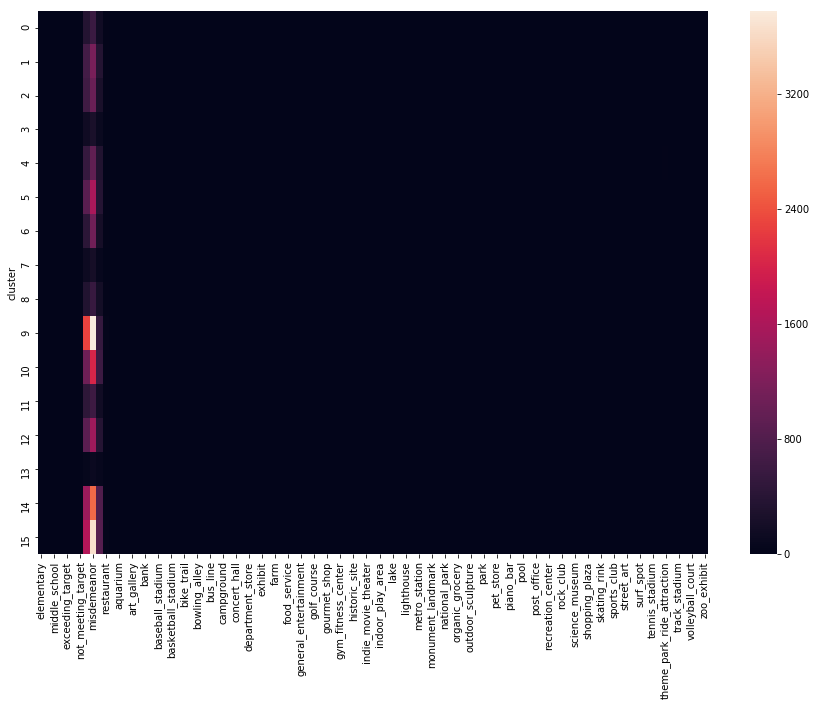

In [911]:
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(heat_gp, ax=ax)

From the heatmap, we can tell clusters 3, 7 and 13 have least average crimes. Clusters 0, 8, and 11 looks to have litle more crimes than the clusters with least crimes. Clusters 9, 10, 12, 14, and 15 have most crimes. I would like to visualize the cluseters with least average crimes only.

In [912]:
heat_least_crime = heat_df.loc[heat_df.cluster.apply(lambda x: x in [3,7,13])]

In [913]:
# Grouping by cluster labels and getting mean value of each feature in each clusters.
heat_least_crime = heat_least_crime.groupby('cluster')[heat_least_crime.columns[1:]].mean()
heat_least_crime

,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.897059,0.323529,0.551471,0.404412,0.389706,0.852941,0.066176,155.823529,261.382353,90.419118,9.551471,0.0,0.0,0.066176,0.029412,0.044118,0.970588,0.419118,0.007353,0.088235,0.0,0.0,0.007353,0.007353,0.044118,0.0,0.051471,0.757353,0.022059,0.014706,0.007353,0.117647,0.330882,0.029412,0.0,0.0,0.014706,0.058824,0.007353,0.036765,0.0,0.0,0.110294,0.0,0.051471,0.691176,0.5,0.227941,0.036765,0.044118,0.022059,0.0,0.007353,0.0,0.036765,0.0,0.0,0.0,0.080882,0.0,0.0,0.0,0.007353,0.0,0.0,0.036765,0.0,0.007353,0.926471,0.014706,0.220588,1.058824,0.0,0.404412,0.073529,0.007353,0.0,0.0,0.022059,0.022059,0.0,0.125,0.0,0.191176,0.0,0.051471,0.044118,0.036765,0.022059,0.051471,0.0,0.507353,0.022059,0.088235,0.022059,0.051471,0.0,0.0,0.0,0.0,0.014706,0.007353,0.0
7,2.000000,3.000000,0.000000,0.000000,2.000000,2.000000,1.000000,132.000000,211.000000,65.000000,13.000000,1.0,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.000000,7.000000,0.000000,1.000000,1.000000,0.0,2.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
13,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,46.000000,116.000000,66.500000,6.500000,0.0,0.0,0.000000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,1.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [914]:
heat_least_crime.shape

(3, 103)

Lets create heatmap again for the clusters 3, 7, and 13.

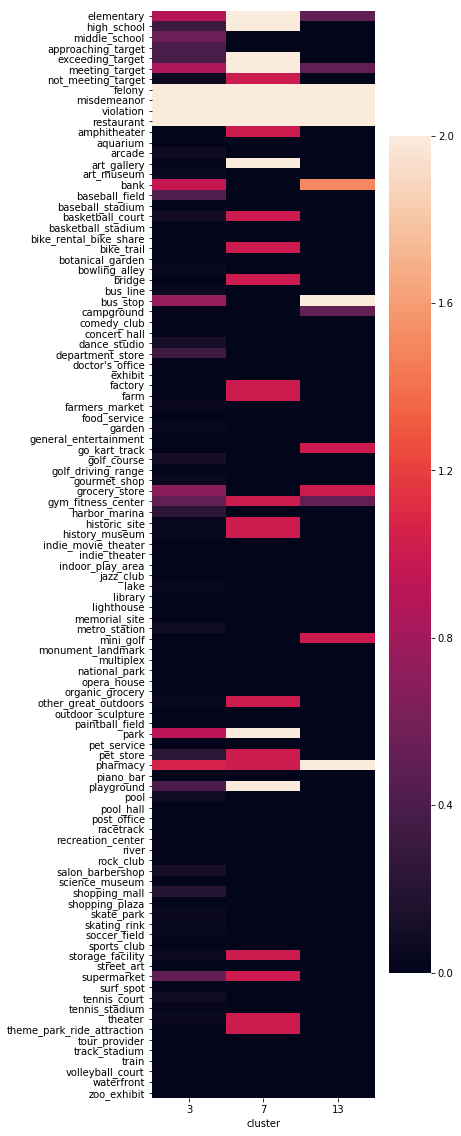

In [915]:
fig, ax = plt.subplots(figsize=(5,20))  
sns.heatmap(heat_least_crime.T, ax=ax, vmin=0, vmax=2)#, cmap= "YlGnBu")

Cluster 7 has either very bright or very dark colors. Cluster 3 has more different shades of colors. Cluster 13 has more very dark color. Lets inspect each of these clusters.

#### Lets inpspect  the clusters 3, 7 and 13:

In [916]:
# Separating clusters
cluster_3 = nyc_df.loc[nyc_df['cluster'] == 3]
cluster_7 = nyc_df.loc[nyc_df['cluster'] == 7]
cluster_13 = nyc_df.loc[nyc_df['cluster'] == 13]

In [917]:
print(f'Number of neighbor in Cluster 3: {len(cluster_3)}')
print(f'Number of neighbor in Cluster 7: {len(cluster_7)}')
print(f'Number of neighbor in Cluster 13: {len(cluster_13)}')

Number of neighbor in Cluster 3: 136
Number of neighbor in Cluster 7: 1
Number of neighbor in Cluster 13: 2


#### Cluster 3

In [918]:
cluster_3

,neighborhood,borough,latitude,longitude,cluster,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
3,Fieldston,Bronx,40.895437,-73.905643,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,104.0,21.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Riverdale,Bronx,40.890834,-73.912585,3,1.0,1.0,0.0,0.0,0.0,2.0,0.0,124.0,202.0,68.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Woodlawn,Bronx,40.898273,-73.867315,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,251.0,579.0,151.0,7.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Baychester,Bronx,40.866858,-73.835798,3,0.0,0.0,2.0,0.0,0.0,2.0,0.0,192.0,400.0,123.0,12.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,City Island,Bronx,40.847247,-73.786488,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,103.0,39.0,15.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,Port Morris,Bronx,40.801664,-73.913221,3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,407.0,1150.0,236.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0

#### Cluster 7:

In [919]:
cluster_7

,neighborhood,borough,latitude,longitude,cluster,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
282,Vinegar Hill,Brooklyn,40.703321,-73.981116,7,2.0,3.0,0.0,0.0,2.0,2.0,1.0,132.0,211.0,65.0,13.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cluster 13

In [920]:
cluster_13

,neighborhood,borough,latitude,longitude,cluster,elementary,high_school,middle_school,approaching_target,exceeding_target,meeting_target,not_meeting_target,felony,misdemeanor,violation,restaurant,amphitheater,aquarium,arcade,art_gallery,art_museum,bank,baseball_field,baseball_stadium,basketball_court,basketball_stadium,bike_rental_bike_share,bike_trail,botanical_garden,bowling_alley,bridge,bus_line,bus_stop,campground,comedy_club,concert_hall,dance_studio,department_store,doctor's_office,exhibit,factory,farm,farmers_market,food_service,garden,general_entertainment,go_kart_track,golf_course,golf_driving_range,gourmet_shop,grocery_store,gym_fitness_center,harbor_marina,historic_site,history_museum,indie_movie_theater,indie_theater,indoor_play_area,jazz_club,lake,library,lighthouse,memorial_site,metro_station,mini_golf,monument_landmark,multiplex,national_park,opera_house,organic_grocery,other_great_outdoors,outdoor_sculpture,paintball_field,park,pet_service,pet_store,pharmacy,piano_bar,playground,pool,pool_hall,post_office,racetrack,recreation_center,river,rock_club,salon_barbershop,science_museum,shopping_mall,shopping_plaza,skate_park,skating_rink,soccer_field,sports_club,storage_facility,street_art,supermarket,surf_spot,tennis_court,tennis_stadium,theater,theme_park_ride_attraction,tour_provider,track_stadium,train,volleyball_court,waterfront,zoo_exhibit
210,Castleton Corners,Staten Island,40.613336,-74.119181,13,1.0,0.0,0.0,0.0,0.0,1.0,0.0,74.0,176.0,85.0,9.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,Manor Heights,Staten Island,40.601810,-74.120594,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,56.0,48.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Finanlly, lets visualize the neighborhoods in clusters 3, 7 and 13 in NYC map.

In [921]:
# Creating dataframe for cluster 3, 7 and 13
cluster3_7_13 = pd.concat([cluster_3, cluster_7, cluster_13], axis = 0, ignore_index=True)

In [923]:
# create map of New York using latitude and longitude values
map_best_neighborhood = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
rainbow = {3: '#6600ff', 7: '#e6005c', 13: '#00ff00'}

# add markers to map
for lat, lng, n, c in zip(cluster3_7_13['latitude'], cluster3_7_13['longitude'], 
                                           cluster3_7_13['neighborhood'], cluster3_7_13['cluster']):
    label = folium.Popup(str(n) + ': cluster-' + str(c), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[c],
        fill=True,
        fill_color=rainbow[c],
        fill_opacity=0.4,
        parse_html=False).add_to(map_best_neighborhood)  
    
map_best_neighborhood

In [ ]:
# Because folium map doesn't work on github, displaying the folium map statically
display(Image(filename='cluster-3-7-13.png', embed=True))

## 8. Results and Discussion <a name="results"></a>

<p>By observing the  visualization of the clusters on NYC map, we can tell that clustering of neighborhoods looks pretty consistence with geographic, urban and suburban characteristics. The more suburban neighborhoods are clustered into cluster-3. Most of the city neighborhoods are clustered into cluster-2. Similarly, neighborhoods with high crimes are clustered into cluster-14 or cluster-15. Cluster-1 also looks very interesting, it contains most of densely populated residential neighborhoods located in between the city (Manhattan) and more suburban neighborhood.</p>
<p>
From the first heatmap, we can tell clusters 3, 7 and 13 have least average crimes. Clusters 0, 8, and 11 looks to have little more crimes than the clusters 3,7, and 13. The clusters 1, 2 and 4 have more crimes than 0, 8 and 11. Clusters 9, 10, 12, 14, and 15 have most crimes. First, I am narrowing down the selection of neighborhoods based on the average crime numbers. So, I am focusing on the clusters with least average crimes only.</p>
<p>From the observation of heatmap of clusters 3, 7 and 13, we can tell cluster 7 is a great neighborhood for living but this cluster got only one neighborhood which is located <b>Vinegar Hill in Brooklyn</b>, just right across the east river from the down town, Manhattan. But cluster 3 is also looks a great collection of 136 neighborhoods. So, lots of choices. Looking at the second NYC map, we can tell this cluster contains most of the suburban neighborhoods and some urban neighborhoods. These neighborhoods got plenty of good schools, lots of natures, amenities, outdoors activities, variety of services and lesser  average crimes. </p>
<p>So, based on this modeling, I would highly recommend the <b>Vinegar Hill </b>neighborhood, if you prefer to live in very close proximity of the city. But if you prefer to live little farther from the city, then the neighborhoods in cluster 3 are very good choice. You can view the neighborhood locations on the second NYC map in purple color and it would help you to make a rough estimation of your choice. Then take a look at the cluster_3 dataframe for more detail features of the neighborhoods.

## 9. Conclusion <a name="conclusion"></a>

<p>
The main purpose of this project was to help the city dwellers to find best neighborhood for living in NYC neighborhoods. Obiously, this project would help new apartment hunters, new home buyers, real estate investors, and business owners. Since the usefulness of a model heavily depends on the quality of dataset, besides the Foursquare venue dataset, NYC neighborhoods, NYC schools, and NYC crime datasets were imported and preprocessed to meet the requirement of this project. The venue data around 1000 meter radius of each neighborhoods were extracted from the Foursquare API and the desired venue types were filtered from this dataset. The NYC neighborhoods, NYC schools, NYC crimes, and venue datasets were then merged into one dataset. The data standardization method was applied to the dataset so the clustering performs better. Clustering of the dataset was performed to segment the neighborhoods into different clusters. Then the mean values of all the features of each clusters were visualized using seaborn heatmap to help narrow down the cluster selections. Then, the selected clusters were visualized again using heatmap to get better picture of the selected clusters. Then, each of the selected clusters were inspected in detail. Finally, the neighborhoods in the selected clusters were visualized on the folium NYC map.
</p>
<p>
The final selection of neighborhood by the city dwellers depends on his or her preference of different venues types, school choices, and the risk of crimes. You can also do your own customization of venues list during the filtering process of the venue data returned by the Foursquare API.
</p>